In [ ]:
!pip -q install -U pip setuptools wheel
!pip -q install -U "pandas==2.2.2" "numpy==2.1.3" jedi
!pip -q install -U datasets sentence-transformers matplotlib scikit-learn aiohttp
!pip -q check || true


In [ ]:
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"


In [ ]:
dataset = load_dataset("empathetic_dialogues")
print(dataset)
print("Train size:", len(dataset["train"]))
print("Example keys:", dataset["train"][0].keys())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

empathetic_dialogues.py: 0.00B [00:00, ?B/s]

Using the latest cached version of the dataset since empathetic_dialogues couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/empathetic_dialogues/default/0.1.0/09bbeed3882a67db98c73952fb3c1c9a85af83dc78f81454c2454382fd03f6cf (last modified on Tue Dec 30 17:58:53 2025).


DatasetDict({
    train: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 76673
    })
    validation: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 12030
    })
    test: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 10943
    })
})
Train size: 76673
Example keys: dict_keys(['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'])


In [ ]:
def build_dialogs_from_empathetic(ds, split="train"):
    dialogs = []
    current = []
    current_conv = None

    for row in ds[split]:
        if row["conv_id"] != current_conv:
            if current:
                dialogs.append({"dialog": current, "conv_id": current_conv})
            current = []
            current_conv = row["conv_id"]

        current.append(row["utterance"])

    if current:
        dialogs.append({"dialog": current, "conv_id": current_conv})

    return dialogs

dialogs_all = build_dialogs_from_empathetic(dataset, split="train")
lengths = [len(d["dialog"]) for d in dialogs_all]
print("Total dialogs:", len(dialogs_all))
print("Length stats: min", min(lengths), "mean", round(np.mean(lengths),2), "max", max(lengths))


Total dialogs: 17844
Length stats: min 1 mean 4.3 max 8


In [ ]:
dialogs = select_dialogs(
    dialogs_all,
    n=200,        # escala razonable
    min_len=6,    # EmpatheticDialogues es corto
    max_len=12,
    seed=SEED
)

print("Selected dialogs:", len(dialogs))
print("Example length:", len(dialogs[0]["dialog"]))


Selected dialogs: 200
Example length: 7


In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")


In [ ]:
def embed_dialog(dialog):
    return model.encode(dialog, normalize_embeddings=True)

def dynamic_coherence(embeddings, alpha=0.7, eps=1e-12):
    C = []
    memory = embeddings[0].copy()
    for t in range(1, len(embeddings)):
        C.append(float(np.dot(embeddings[t], memory)))
        memory = alpha * memory + (1 - alpha) * embeddings[t]
        n = float(np.linalg.norm(memory))
        memory = memory / max(n, eps)
    return np.array(C, dtype=float)

def local_similarity(embeddings):
    return np.array([float(np.dot(embeddings[t], embeddings[t-1])) for t in range(1, len(embeddings))], dtype=float)

def detect_breaks_topk(signal, p=10, min_k=0, max_k=None):
    """
    Detecta rupturas como las k peores caídas de ΔC.
    k = ceil(p% * n_deltas), acotado por [min_k, max_k] si se da.
    Permite k=0 si min_k=0 y el diálogo es demasiado corto o si quieres permitir 'sin rupturas'.
    """
    delta = np.diff(signal)
    n = len(delta)
    if n <= 0:
        return np.array([], dtype=int), np.nan, delta

    k = math.ceil((p/100) * n)
    if max_k is not None:
        k = min(k, max_k)
    k = max(min_k, k)

    if k == 0:
        return np.array([], dtype=int), np.nan, delta

    idx = np.argsort(delta)[:k]              # k deltas más negativos
    breaks = np.sort(idx + 1)                # +1 para mapear a índice en la señal
    thr = float(delta[idx[-1]])              # umbral implícito: k-ésimo peor
    return breaks, thr, delta

def shuffle_dialog(dialog, seed=42):
    rng = random.Random(seed)
    shuffled = dialog.copy()
    rng.shuffle(shuffled)
    return shuffled


In [ ]:
results = []

ALPHA = 0.7
P_BREAK = 10
MIN_K = 0           # permite 0 rupturas si quieres (recomendado)
MAX_K = 3           # cap para no marcar demasiadas en diálogos medianos (ajustable)

for i, d in enumerate(dialogs):
    dialog = d["dialog"]
    n_turns = len(dialog)

    # Real
    emb = embed_dialog(dialog)
    C_dyn = dynamic_coherence(emb, alpha=ALPHA)
    C_base = local_similarity(emb)
    breaks, thr, delta = detect_breaks_topk(C_dyn, p=P_BREAK, min_k=MIN_K, max_k=MAX_K)

    # Control shuffled (mismo contenido, orden aleatorio)
    dialog_sh = shuffle_dialog(dialog, seed=SEED + i)
    emb_sh = embed_dialog(dialog_sh)
    C_dyn_sh = dynamic_coherence(emb_sh, alpha=ALPHA)
    C_base_sh = local_similarity(emb_sh)
    breaks_sh, thr_sh, delta_sh = detect_breaks_topk(C_dyn_sh, p=P_BREAK, min_k=MIN_K, max_k=MAX_K)

    # Métricas agregadas (pero derivadas de señal dinámica)
    def safe_corr(a, b):
        if len(a) < 2 or len(b) < 2:
            return np.nan
        return float(np.corrcoef(a, b)[0,1])

    row = {
        "dialog_id": i,
        "conv_id": d.get("conv_id", None),
        "n_turns": n_turns,

        # Señales (para inspección / figuras)
        "C_dyn": C_dyn.tolist(),
        "C_base": C_base.tolist(),
        "delta_C_dyn": delta.tolist(),
        "break_positions": breaks.tolist(),
        "break_threshold_delta": thr,
        "n_breaks": int(len(breaks)),

        # Resúmenes real
        "mean_Cdyn": float(np.mean(C_dyn)),
        "mean_Cbase": float(np.mean(C_base)),
        "auc_Cdyn": float(np.sum(C_dyn)),
        "vol_Cdyn": float(np.std(C_dyn)),
        "vol_Cbase": float(np.std(C_base)),
        "corr_dyn_base": safe_corr(C_dyn, C_base),

        # Control shuffled (resúmenes)
        "mean_Cdyn_sh": float(np.mean(C_dyn_sh)),
        "mean_Cbase_sh": float(np.mean(C_base_sh)),
        "auc_Cdyn_sh": float(np.sum(C_dyn_sh)),
        "vol_Cdyn_sh": float(np.std(C_dyn_sh)),
        "vol_Cbase_sh": float(np.std(C_base_sh)),
        "corr_dyn_base_sh": safe_corr(C_dyn_sh, C_base_sh),
        "n_breaks_sh": int(len(breaks_sh)),

        # Diferencias (lo que quieres mostrar en Results)
        "d_mean_Cdyn": float(np.mean(C_dyn) - np.mean(C_dyn_sh)),
        "d_auc_Cdyn": float(np.sum(C_dyn) - np.sum(C_dyn_sh)),
        "d_vol_Cdyn": float(np.std(C_dyn) - np.std(C_dyn_sh)),
        "d_n_breaks": int(len(breaks) - len(breaks_sh)),
    }

    results.append(row)

df = pd.DataFrame(results)
df.head()


,dialog_id,conv_id,n_turns,C_dyn,C_base,delta_C_dyn,break_positions,break_threshold_delta,n_breaks,mean_Cdyn,...,mean_Cbase_sh,auc_Cdyn_sh,vol_Cdyn_sh,vol_Cbase_sh,corr_dyn_base_sh,n_breaks_sh,d_mean_Cdyn,d_auc_Cdyn,d_vol_Cdyn,d_n_breaks
0,0,hit:10362_conv:20725,7,"[0.24903598427772522, 0.37973785400390625, 0.3...","[0.24903598427772522, 0.5100577473640442, 0.20...","[0.13070186972618103, -0.057200998067855835, 0...",[5],-0.138213,1,0.361841,...,0.223097,2.096824,0.107787,0.067572,0.292179,1,0.012370,0.074222,-0.036436,0
1,1,hit:1332_conv:2665,6,"[0.07440768927335739, 0.3444278836250305, 0.24...","[0.07440768927335739, 0.2315276563167572, 0.14...","[0.2700201943516731, -0.09917527437210083, -0....",[2],-0.099175,1,0.208479,...,0.197405,0.957320,0.045180,0.056818,0.998656,1,0.017015,0.085077,0.042668,0
2,2,hit:132_conv:264,8,"[0.41993021965026855, 0.3561576008796692, 0.47...","[0.41993021965026855, 0.2258075773715973, 0.50...","[-0.06377261877059937, 0.11738267540931702, -0...",[5],-0.259076,1,0.311186,...,0.205328,2.119198,0.154524,0.141220,0.800196,1,0.008444,0.059107,-0.026009,0
3,3,hit:11270_conv:22540,6,"[0.6181551218032837, 0.19589072465896606, 0.35...","[0.6181551218032837, 0.13314394652843475, 0.16...","[-0.4222643971443176, 0.1566050946712494, 0.15...",[1],-0.422264,1,0.383335,...,0.315548,1.555778,0.111722,0.190305,0.755767,1,0.072179,0.360896,0.048858,0
4,4,hit:3583_conv:7166,8,"[0.039571281522512436, 0.3016809821128845, 0.3...","[0.039571281522512436, 0.18024519085884094, 0....","[0.2621097005903721, 0.09320071339607239, 0.14...",[4],-0.044248,1,0.421372,...,0.366292,3.311479,0.123826,0.119720,0.558806,1,-0.051696,-0.361874,0.060155,0


In [ ]:
print("N dialogs:", len(df))
print("\n=== REAL vs SHUFFLED (promedios) ===")
print("mean_Cdyn:", df["mean_Cdyn"].mean(), " | shuffled:", df["mean_Cdyn_sh"].mean())
print("auc_Cdyn:", df["auc_Cdyn"].mean(),   " | shuffled:", df["auc_Cdyn_sh"].mean())
print("vol_Cdyn:", df["vol_Cdyn"].mean(),   " | shuffled:", df["vol_Cdyn_sh"].mean())
print("n_breaks:", df["n_breaks"].mean(),   " | shuffled:", df["n_breaks_sh"].mean())

print("\n=== DIFERENCIAS (real - shuffled) ===")
print("d_mean_Cdyn mean:", df["d_mean_Cdyn"].mean())
print("d_auc_Cdyn  mean:", df["d_auc_Cdyn"].mean())
print("d_vol_Cdyn  mean:", df["d_vol_Cdyn"].mean())
print("d_n_breaks  mean:", df["d_n_breaks"].mean())

print("\n% diálogos con d_auc_Cdyn > 0:", (df["d_auc_Cdyn"] > 0).mean())


N dialogs: 200

=== REAL vs SHUFFLED (promedios) ===
mean_Cdyn: 0.36673873515879474  | shuffled: 0.35234240067779043
auc_Cdyn: 2.105666285911575  | shuffled: 2.0245232594339178
vol_Cdyn: 0.1292649448763818  | shuffled: 0.1365802749505526
n_breaks: 1.0  | shuffled: 1.0

=== DIFERENCIAS (real - shuffled) ===
d_mean_Cdyn mean: 0.014396334481004271
d_auc_Cdyn  mean: 0.08114302647765725
d_vol_Cdyn  mean: -0.007315330074170812
d_n_breaks  mean: 0.0

% diálogos con d_auc_Cdyn > 0: 0.715


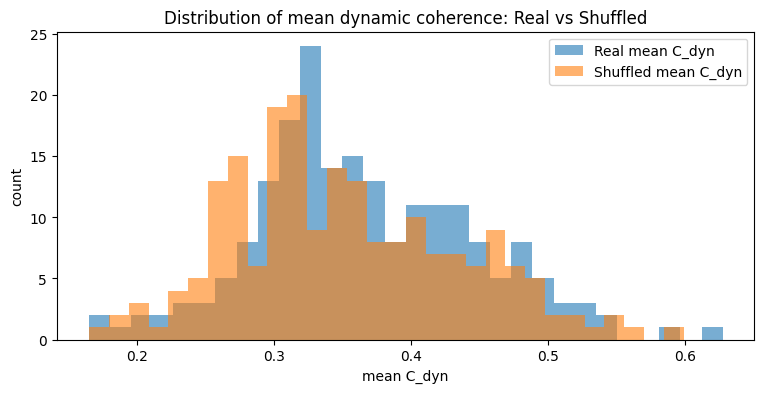

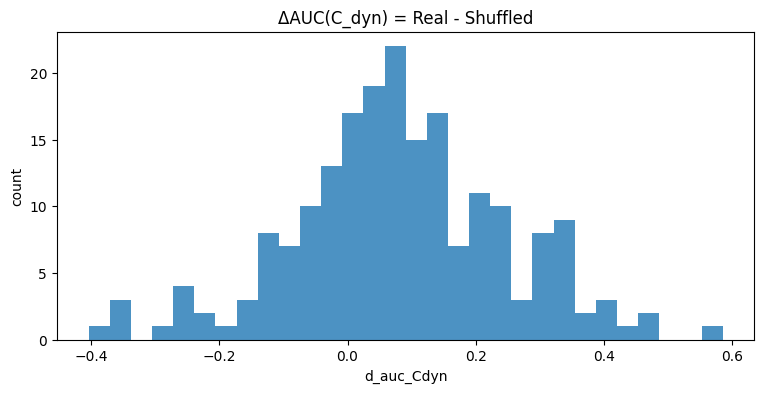

In [ ]:
plt.figure(figsize=(9,4))
plt.hist(df["mean_Cdyn"], bins=30, alpha=0.6, label="Real mean C_dyn")
plt.hist(df["mean_Cdyn_sh"], bins=30, alpha=0.6, label="Shuffled mean C_dyn")
plt.title("Distribution of mean dynamic coherence: Real vs Shuffled")
plt.xlabel("mean C_dyn")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
plt.hist(df["d_auc_Cdyn"], bins=30, alpha=0.8)
plt.title("ΔAUC(C_dyn) = Real - Shuffled")
plt.xlabel("d_auc_Cdyn")
plt.ylabel("count")
plt.show()


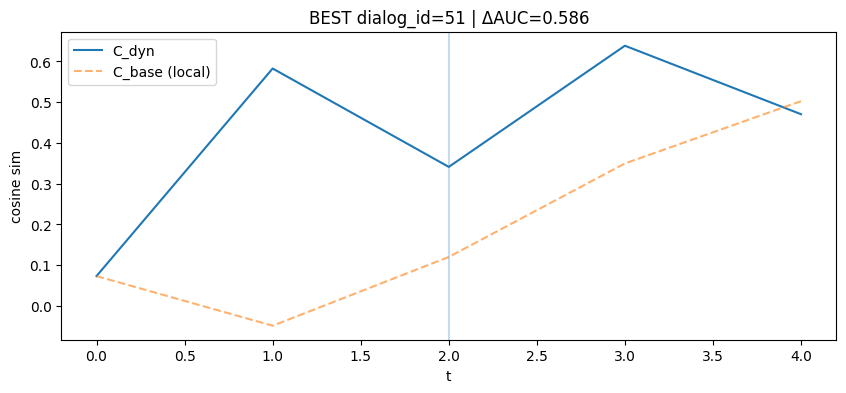

Dialog text:
00: I got all As in my first college semester_comma_ and it made me feel really good about myself
01: Wow. That is great.  Not everyone can say that.
02: No_comma_ but I do think they made it a little easy to get As in some classes_comma_ especially the general education courses. I got an A in biology and definitely don't remember much from it
03: Most struggle in their first year.  That is amazing that you did so well.
04: I appreciate it. I'm a little bit of an older student_comma_ so I didn't have much to worry about in the way of feeling overwhelmed
05: I am an older student too so I hope things go well for me in school.
Break positions: [2]


In [ ]:
def plot_dialog_signals(C_dyn, C_base, breaks, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(C_dyn, label="C_dyn")
    plt.plot(C_base, "--", alpha=0.6, label="C_base (local)")
    for b in breaks:
        plt.axvline(b, alpha=0.25)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("cosine sim")
    plt.legend()
    plt.show()

# Selecciona el dialogo con mayor ΔAUC
best_id = int(df.sort_values("d_auc_Cdyn", ascending=False).iloc[0]["dialog_id"])
d = dialogs[best_id]

# Recalcula señales para plot (o usa las guardadas)
C_dyn = np.array(df.loc[df.dialog_id==best_id, "C_dyn"].values[0])
C_base = np.array(df.loc[df.dialog_id==best_id, "C_base"].values[0])
breaks = np.array(df.loc[df.dialog_id==best_id, "break_positions"].values[0])

plot_dialog_signals(C_dyn, C_base, breaks, title=f"BEST dialog_id={best_id} | ΔAUC={df.loc[df.dialog_id==best_id,'d_auc_Cdyn'].values[0]:.3f}")

print("Dialog text:")
for t, utt in enumerate(d["dialog"]):
    print(f"{t:02d}: {utt}")
print("Break positions:", breaks.tolist())


In [ ]:
df.to_csv("dynamic_coherence_results_scaled_with_shuffle.csv", index=False)

from google.colab import files
files.download("dynamic_coherence_results_scaled_with_shuffle.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>